In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available!")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

MPS backend is available!


In [3]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [4]:
def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_loss_with_uh(uh_vem, uh):
    """
    Compute the loss function as (uh - uh_vem)^2 using PyTorch.

    Parameters:
    uh_vem (torch.Tensor): Solution vector from VEM (ndof x 1)
    uh (torch.Tensor): Solution vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    
    # Detach uh_vem if necessary to avoid tracking gradients
    uh_vem = torch.tensor(uh_vem, requires_grad=True)

    # Compute the loss (squared residual)
    loss = torch.sum((uh - uh_vem)**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

In [5]:
def generate_geometry(num_elements_per_edge, L):
    
    x_coords = np.linspace(0, L, num_elements_per_edge + 1)
    y_coords = np.linspace(0, L, num_elements_per_edge + 1)

    top_nodes = np.array([[x, L] for x in x_coords if x != 0])
    left_nodes = np.array([[0, y] for y in y_coords])
    right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

    nodes = np.vstack([left_nodes, top_nodes, right_nodes])

    elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
    flatten_elements = elements.flatten()

    supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

    return nodes, elements, supp

def plot_nodes(nodes, elements):
    """
    Plot the nodes and elements of a 2D mesh.

    Parameters:
    nodes (np.ndarray): Node coordinates (n_nodes x 2)
    elements (np.ndarray): Element connectivity (n_elements x n_nodes_per_element)
    """

    _, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

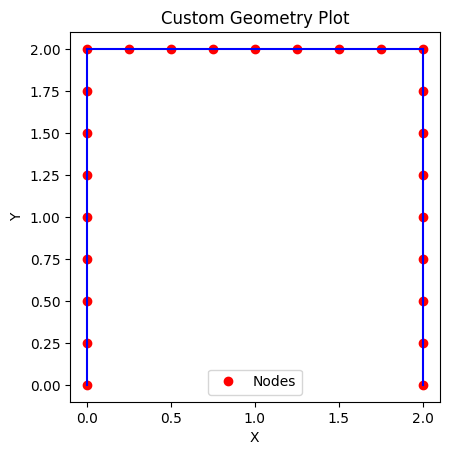


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.17339955e-08
 -2.14427330e-05  2.27723133e-07  1.12629721e-07 -4.28854659e-05
 -1.24878169e-06  2.62794616e-07 -5.91198655e-05  1.01313694e-07
 -2.80378315e-08 -6.49375985e-05  2.27919706e-06 -3.96031942e-10
 -6.55469981e-05 -2.44648029e-06 -9.34621382e-07 -6.61563978e-05
  9.97413425e-06  4.01151099e-06 -6.67657974e-05 -4.94893421e-05
 -1.90264993e-05 -6.73751970e-05  2.33847275e-04 -1.89877264e-05
 -2.13883922e-05  1.34893551e-04 -1.89489536e-05 -3.95818289e-07
  3.38934285e-05 -1.89101807e-05  3.21478705e-06 -4.16219740e-06
 -1.88714079e-05  1.64297824e-06 -7.56588465e-06 -1.88326351e-05
  1.15968873e-07 -3.80380196e-06 -1.87938622e-05 -1.31417160e-07
  2.67110206e-06 -1.87550894e-05 -1.49977127e-06 -1.27715466e-05
 -1.87163165e-05  4.87519701e-06  6.46176812e-05 -5.93255208e-06
  4.26579739e-06  3.75985832e-05 -4.48395776e-08  3.65639776e-06
  9.44926570e-06  9.87875854e-0

In [6]:
num_elements_per_edge = 8

# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# Generate the geometry
nodes, elements, supp = generate_geometry(num_elements_per_edge, L)

# Plot the nodes
plot_nodes(nodes, elements)


# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

In [7]:
# # Define neural network for the beam problem
# class BeamApproximator(nn.Module):
#     def __init__(self, input_dim, layers, ndof):
#         super(BeamApproximator, self).__init__()
#         # First layer from input to the first hidden layer
#         self.fin = nn.Linear(input_dim, layers[0])
        
#         # Hidden layers
#         self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
#         # Final output layer from the last hidden layer to the output (ndof)
#         self.fout = nn.Linear(layers[-1], ndof)

#     def forward(self, x):
#         # Pass through the first layer
#         z = torch.relu(self.fin(x))
        
#         # Pass through the hidden layers
#         for layer in self.hidden:
#             z = torch.sigmoid(layer(z))
#             # z = torch.nn.functional.leaky_relu(layer(z), negative_slope=0.01)
        
#         # Final output layer
#         z = self.fout(z)
        
#         return z

# # Assuming nodes, K, and f are already defined
# ndof = 3 * len(nodes)
# input_dim = 2*len(nodes)

# nodes = nodes.flatten()
# nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# lr = 1e-3

# # Initialize the model and optimizer
# # layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024]
# layers = [128, 128, 256, 256, 512, 512, 512, 1024]
# # layers = [128, 256, 512]
# model = BeamApproximator(input_dim, layers, ndof)
# # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
# # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
# # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

# K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
# f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

# epochs = 70
# sub_epochs = 1000
# loss_buffer = float('inf')  # Initialize with a large value
# loss_values = []

# penalty_coefficient = 2

# for epoch in range(epochs):
#     for sub_epoch in range(sub_epochs):
#         optimizer.zero_grad()
#         uh = model(nodes)
        
#         # Compute the loss
#         loss = compute_loss(K, uh, f)
#         loss_bc = compute_boundary_loss(uh, supp) # TODO: improve this loss
#         total_loss = loss + penalty_coefficient*loss_bc

#         # total_loss = loss + penalty_coefficient*loss_bc
        
#         # Only update the model if the new loss is smaller than the loss_buffer
        
#         total_loss.backward()

#         # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()
#         loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
#         if epoch > 0:
#             loss_values.append(total_loss.item())
        
#         print(f'Epoch: {epoch + 1}, Sub-epoch: {sub_epoch + 1}, Loss: {loss.item()}, BC Loss: {loss_bc.item()}, Total Loss: {total_loss.item()}')
    
#     # Early stopping condition if the loss is not improving
#     # if total_loss.item() >= loss_buffer:
#     #     print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
#     #     break
    
# # Set the model to evaluation mode
# model.eval()

# # Ensure gradients are not tracked during prediction
# with torch.no_grad():
#     # Use the trained model to make predictions
#     predicted_displacements = model(nodes)

# # Print or use the predicted displacements
# print("Predicted displacements:", predicted_displacements)

# l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
# energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
# h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

# print(f"L2 error: {l2_error}")
# print(f"Energy error: {energy_error}")
# print(f"H1 error: {h1_error}")

# plt.plot(loss_values)
# plt.xlabel('Epochs (Sub-Epochs)')
# plt.ylabel('Loss')
# plt.title('Training Loss over Epochs')
# plt.show()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

epochs = 10
sub_epochs = 1000
lr = 0.000000001

L2 error: 528.4882666709253
Energy error: 109900992.0
H1 error: 0.17845797538757324



---------
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

epochs = 50
sub_epochs = 1000
lr = 0.000000001

L2 error: 480.450057584146
Energy error: 97199968.0
H1 error: 0.16223660111427307

In [21]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.sigmoid(layer(z))
            # z = torch.nn.functional.leaky_relu(layer(z), negative_slope=0.01)
        
        # Final output layer
        z = self.fout(z)
        
        return z
    
class ResidualBeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(ResidualBeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z_res = z
            z = torch.sigmoid(layer(z))

            # Residual block
            if z.shape == z_res.shape:
                z = z + z_res
        
        # Final output layer
        z = self.fout(z)
        
        return z

def train(epochs, nodes, K, f, E, A, I, verbose=True, use_residual=False):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

    material_params = torch.tensor([E, A, I], dtype=torch.float32, requires_grad=True)

    input_vector = torch.cat([nodes, material_params])

    lr = 1e-3

    # Initialize the model and optimizer
    layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
    # layers = [128, 128, 256, 256, 512, 512, 512, 512]
    # layers = [128, 256, 512]
    if use_residual:
        model = ResidualBeamApproximator(input_dim, layers, ndof)
    else:
        model = BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    # uh = torch.linalg.solve(K, f)

    # epochs = 10000
    loss_buffer = float('inf')  # Initialize with a large value
    loss_values = []

    # Scaling factor for loss
    alpha = 1e-17

    for epoch in range(epochs):
        optimizer.zero_grad()
        uh = model(input_vector)
        
        # Compute the loss
        loss = compute_loss_with_uh(uh_vem, uh)
        # loss = alpha * compute_loss(K, uh, f)
        total_loss = loss

        # total_loss = loss + penalty_coefficient*loss_bc
        
        # Only update the model if the new loss is smaller than the loss_buffer
        
        total_loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
        if epoch > 0:
            loss_values.append(total_loss.item())
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
        
        # Early stopping condition if the loss is not improving
        # if total_loss.item() >= loss_buffer:
        #     print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
        #     break
    
    if verbose:
        print("Training complete.")
        plt.plot(loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model

Epoch: 1, Total Loss: 7.0802908752739455
Epoch: 2, Total Loss: 14.769918365809694
Epoch: 3, Total Loss: 5.300466687692188
Epoch: 4, Total Loss: 3.36553313002937
Epoch: 5, Total Loss: 4.033739955071146
Epoch: 6, Total Loss: 3.583025255157696
Epoch: 7, Total Loss: 2.57774404859946
Epoch: 8, Total Loss: 1.8936321193901438
Epoch: 9, Total Loss: 1.6778275640054796
Epoch: 10, Total Loss: 1.5776068466370725
Epoch: 11, Total Loss: 1.361040582286476
Epoch: 12, Total Loss: 1.0896038655957647
Epoch: 13, Total Loss: 0.8964298762937617
Epoch: 14, Total Loss: 0.8122774337451555
Epoch: 15, Total Loss: 0.7760022226248653
Epoch: 16, Total Loss: 0.7220043138851137
Epoch: 17, Total Loss: 0.6297083729389391
Epoch: 18, Total Loss: 0.5168036085005993
Epoch: 19, Total Loss: 0.4117571301913917
Epoch: 20, Total Loss: 0.33368349210957066
Epoch: 21, Total Loss: 0.2864807006078869
Epoch: 22, Total Loss: 0.262913018515174
Epoch: 23, Total Loss: 0.25183002994661413
Epoch: 24, Total Loss: 0.24362219974710128
Epoch: 

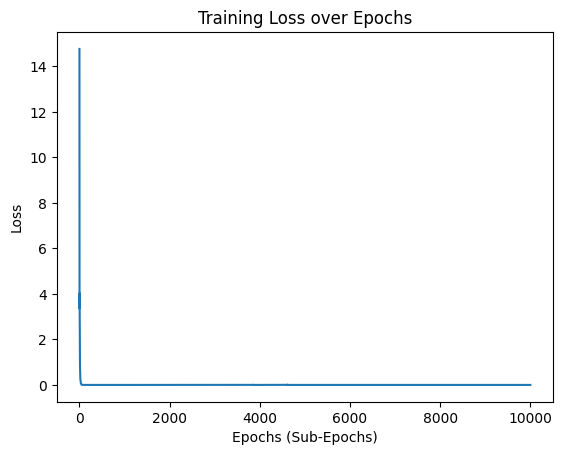

In [25]:
input_vector, model = train(epochs=10000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, use_residual=False)

In [23]:
def test(input_vector, model, uh_vem, K, f):
    # Set the model to evaluation mode
    model.eval()

    # Move the input vector, K, f, and uh_vem to the same device
    input_vector = input_vector
    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    uh_vem = torch.tensor(uh_vem, dtype=torch.float32)

    # Ensure gradients are not tracked during prediction
    with torch.no_grad():
        # Use the trained model to make predictions
        predicted_displacements = model(input_vector)

    # Print or use the predicted displacements
    print("Predicted displacements:", predicted_displacements)

    # Compute errors and ensure tensors are on the same device
    l2_error = compute_l2_error(uh_vem, predicted_displacements).item()
    energy_error = compute_energy_error(K, uh_vem, predicted_displacements).item()
    h1_error = compute_h1_norm(K, uh_vem, predicted_displacements).item()

    # print(f"L2 error: {l2_error}")
    # print(f"Energy error: {energy_error}")
    # print(f"H1 error: {h1_error}")

    return predicted_displacements, l2_error, energy_error, h1_error

In [26]:
predicted_displacements, l2_error, energy_error, h1_error = test(input_vector, model, uh_vem, K, f)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-1.2573e-08, -2.6077e-08, -4.6566e-09, -1.5832e-08, -2.1453e-05,
         2.3842e-07,  1.1269e-07, -4.2881e-05, -1.2452e-06,  2.8126e-07,
        -5.9134e-05,  1.0524e-07, -2.8871e-08, -6.4916e-05,  2.2817e-06,
         3.7253e-09, -6.5541e-05, -2.4480e-06, -9.4203e-07, -6.6180e-05,
         9.9856e-06,  4.0019e-06, -6.6764e-05, -4.9480e-05, -1.9037e-05,
        -6.7372e-05,  2.3386e-04, -1.9000e-05, -2.1410e-05,  1.3490e-04,
        -1.8951e-05, -4.1956e-07,  3.3900e-05, -1.8907e-05,  3.2112e-06,
        -4.1369e-06, -1.8852e-05,  1.6422e-06, -7.5633e-06, -1.8831e-05,
         1.3877e-07, -3.7784e-06, -1.8812e-05, -1.3551e-07,  2.6673e-06,
        -1.8743e-05, -1.4920e-06, -1.2767e-05, -1.8723e-05,  4.8680e-06,
         6.4611e-05, -5.9581e-06,  4.2600e-06,  3.7581e-05, -5.8208e-08,
         3.6601e-06,  9.4566e-06,  9.8720e-07,  3.0480e-06, -1.2275e-06,
         5.6252e-07,  2.4373e-06, -2.2748e-06,  1.5087e-07,  1.8406e-06,
        -1.0496e-06, -1.49

In [ ]:
epochs = [8000, 10000, 12000, 14000, 16000, 18000, 20000]
models = []
for epoch in epochs:
    print(f"Training model for {epoch} epochs...")
    input_vector, model = train(epochs=epoch, nodes=nodes, K=K, f=f, E=E, A=A, I=I, verbose=False)
    models.append(model)

In [ ]:
input_vector, model = train(epochs=22000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, verbose=False)
models.append(model)

In [ ]:
for epoch_ind, model in enumerate(models):
    predicted_displacements, l2_error, energy_error, h1_error = test(input_vector, model, uh_vem, K, f)
    print(f"Epoch: {epochs[epoch_ind]}")
    print(f"L2 error: {l2_error}")
    print(f"Energy error: {energy_error}")
    print(f"H1 error: {h1_error}")
    print()